# Practice

In [2]:
import os, copy
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [58]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [59]:
!nvidia-smi

Mon Mar 10 08:06:10 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0              27W /  70W |  13848MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# 데이터 경로
DATA_PATH = os.getenv('HOME') + '/aiffel/object_detection/data'

In [4]:
# KITTI 데이터셋 다운로드 (30~40분 정도 소요)
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=DATA_PATH,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

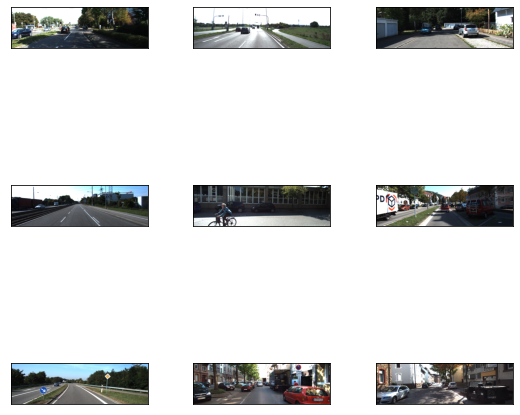

In [5]:
# KITTI 데이터셋 샘플
_ = tfds.show_examples(ds_train, ds_info)

In [6]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.77, -1.6 ,  2.26,  1.24,  1.16], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.3232    , 0.3949839 , 0.53114665, 0.41915458],
       [0.32074666, 0.37339774, 0.54176   , 0.39580515],
       [0.18386666, 0.8975362 , 0.58896   , 0.95774555],
       [0.39893332, 0.5368518 , 0.55608   , 0.5534541 ],
       [0.39824   , 0.55902576, 0.55848   , 0.5752093 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.53, 0.61, 0.73],
       [1.61, 0.54, 0.87],
       [1.66, 0.8 , 0.5 ],
       [1.89, 0.61, 0.92],
       [1.91, 0.69, 0.77]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-2.23,  1.6 , 14.69],
       [-2.74,  1.59, 14.5 ],
       [ 6.07,  1.46,  8.32],
       [ 2.11,  1.69, 23.66],
       [ 3.01,  1.69, 23.48]], dtype=float32)>, 'oc

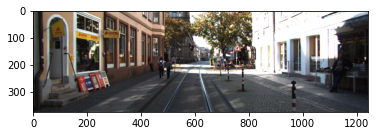

In [7]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys()))
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
plt.imshow(img)
plt.show()

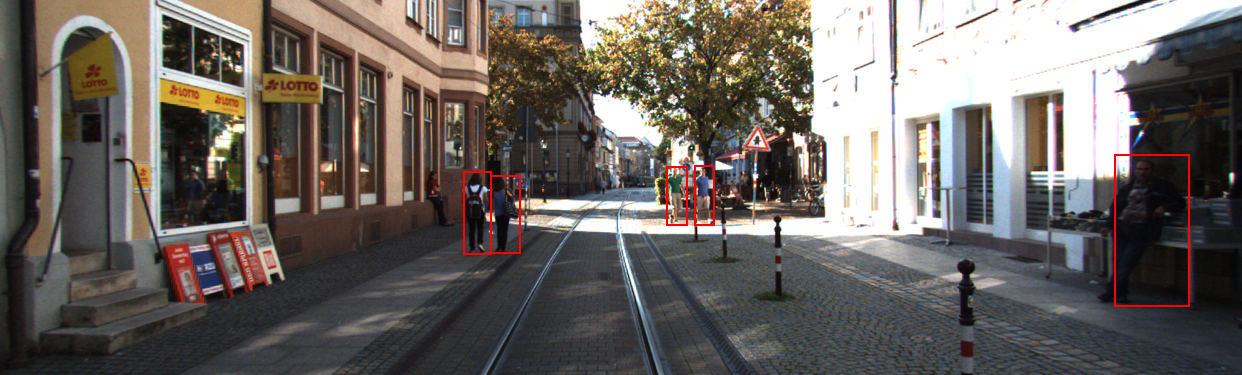

In [8]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    x_min = object_bbox[:,1] * width
    x_max = object_bbox[:,3] * width
    y_min = height - object_bbox[:,0] * height
    y_max = height - object_bbox[:,2] * height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)

    return input_image

visualize_bbox(img, objects['bbox'].numpy())

### 데이터 파이프 라인
1. x와 y좌표 위치 교체
2. 무작위로 수평 뒤집기(Flip)
3. 이미지 크기 조정 및 패딩 추가
4. 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정

In [10]:
# x와 y좌표 위치 교체
def swap_xy(boxes):
    return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)

# 무작위로 수평 뒤집기(Flip)
def random_flip_horizontal(image, boxes):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        boxes = tf.stack(
           [1 - boxes[:, 2], boxes[:, 1], 1 - boxes[:, 0], boxes[:, 3]], axis=-1
        )
        
    return image, boxes

# 이미지 크기 조정 및 패딩 추가
def resize_and_pad_image(image, training=True):

    min_side = 800.0
    max_side = 1333.0
    min_side_range = [640, 1024]
    stride = 128.0
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype=tf.float32)
    if training:
        min_side = tf.random.uniform((), min_side_range[0], min_side_range[1], dtype=tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
        ratio = max_side / tf.reduce_max(image_shape)
    image_shape = ratio * image_shape
    image = tf.image.resize(image, tf.cast(image_shape, dtype=tf.int32))
    padded_image_shape = tf.cast(
        tf.math.ceil(image_shape / stride) * stride, dtype=tf.int32
    )
    image = tf.image.pad_to_bounding_box(
        image, 0, 0, padded_image_shape[0], padded_image_shape[1]
    )
    return image, image_shape, ratio

# 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
def convert_to_xywh(boxes):
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1,
    )

# 위 함수들 연결
def preprocess_data(sample):
    image = sample["image"]
    bbox = swap_xy(sample["objects"]["bbox"])
    class_id = tf.cast(sample["objects"]["type"], dtype=tf.int32)

    image, bbox = random_flip_horizontal(image, bbox)
    image, image_shape, _ = resize_and_pad_image(image)

    bbox = tf.stack(
        [
            bbox[:, 0] * image_shape[1],
            bbox[:, 1] * image_shape[0],
            bbox[:, 2] * image_shape[1],
            bbox[:, 3] * image_shape[0],
        ],
        axis=-1,
    )
    bbox = convert_to_xywh(bbox)
    return image, bbox, class_id

In [12]:
# RetinaNet에서는 FPN을 사용하기 때문에 Anchor Box가 더 많이 필요합니다. 
# FPN의 각 층마다 Anchor Box가 필요하기 때문입니다. 
# RetinaNet의 FPN에서 pyramid level은 개수가 미리 약속되어 있기 때문에 각 level에서 만들어지는 Anchor Box도 약속되어 있습니다.
# 논문과 같은 형태로 Anchor Box 생성
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.5, 1.0, 2.0]
        self.scales = [2 ** x for x in [0, 1 / 3, 2 / 3]]

        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(3, 8)]
        self._areas = [x ** 2 for x in [32.0, 64.0, 128.0, 256.0, 512.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []
        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios:
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis=-1), [1, 1, 2]
                )
                for scale in self.scales:
                    anchor_dims.append(scale * dims)
            anchor_dims_all.append(tf.stack(anchor_dims, axis=-2))
        return anchor_dims_all

    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype=tf.float32) + 0.5
        ry = tf.range(feature_height, dtype=tf.float32) + 0.5
        centers = tf.stack(tf.meshgrid(rx, ry), axis=-1) * self._strides[level - 3]
        centers = tf.expand_dims(centers, axis=-2)
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        dims = tf.tile(
            self._anchor_dims[level - 3], [feature_height, feature_width, 1, 1]
        )
        anchors = tf.concat([centers, dims], axis=-1)
        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i),
                tf.math.ceil(image_width / 2 ** i),
                i,
            )
            for i in range(3, 8)
        ]
        return tf.concat(anchors, axis=0)

In [13]:
# 중심 좌표 (center format)로 표현된 바운딩 박스를 좌상단-우하단 (corner format)으로 변환
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1,
    )

# IOU 계산
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])
    intersection = tf.maximum(0.0, rd - lu)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(
        boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8
    )
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [14]:
# compute_iou 함수를 이용해서 IoU를 구하고 그 IoU를 기준으로 물체에 해당하는 Anchor Box와 배경이 되는 Anchor Box를 지정해 줍니다. 
# 그리고 그 Anchor Box와 실제 Bounding Box의 미세한 차이를 계산합니다. 
# 상하좌우의 차이, 가로세로 크기의 차이를 기록해 두는데 가로세로 크기는 로그를 사용해서 기록해 둡니다.

# 이 과정에서 variance가 등장하는데 관례적으로 Anchor Box를 사용할 때 등장합니다.
# 어디에도 정확한 이유가 등장하지는 않지만 상하좌우의 차이에는 0.1, 가로세로 크기의 차이에는 0.2를 사용합니다.
# 이와 관련하여 통계적 추정치를 계산할 때 분산으로 나눠주는 것 때문이라는 의견이 있습니다.
class LabelEncoder:

    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32
        )

    def _match_anchor_boxes(
        self, anchor_boxes, gt_boxes, match_iou=0.5, ignore_iou=0.4
    ):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis=1)
        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)
        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype=tf.float32),
            tf.cast(ignore_mask, dtype=tf.float32),
        )

    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:]),
            ],
            axis=-1,
        )
        box_target = box_target / self._box_variance
        return box_target

    def _encode_sample(self, image_shape, gt_boxes, cls_ids):
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
            label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
            labels = labels.write(i, label)
        batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [15]:
# FPN(Feature Pyramid Network)
class FeaturePyramid(tf.keras.layers.Layer):

    def __init__(self, backbone):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid")
        self.backbone = backbone
        self.conv_c3_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = tf.keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = tf.keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = tf.keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = tf.keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output

In [16]:
# lass를 예측하는 head와 box를 예측하는 head가 별도로 존재
def build_head(output_filters, bias_init):
    head = tf.keras.Sequential([tf.keras.Input(shape=[None, None, 256])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    for _ in range(4):
        head.add(
            tf.keras.layers.Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)
        )
        head.add(tf.keras.layers.ReLU())
    head.add(
        tf.keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [17]:
# RetinaNet의 backbone은 ResNet50
# FPN에 이용할 수 있도록 중간 레이어도 output으로 연결
def get_backbone():
    backbone = tf.keras.applications.ResNet50(
        include_top=False, input_shape=[None, None, 3]
    )
    c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
    ]
    return tf.keras.Model(
        inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
    )

In [18]:
# RetinaNet 생성
class RetinaNet(tf.keras.Model):

    def __init__(self, num_classes, backbone):
        super(RetinaNet, self).__init__(name="RetinaNet")
        self.fpn = FeaturePyramid(backbone)
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=False):
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []
        for feature in features:
            box_outputs.append(tf.reshape(self.box_head(feature), [N, -1, 4]))
            cls_outputs.append(
                tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])
            )
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        return tf.concat([box_outputs, cls_outputs], axis=-1)

### LOSS
- RetinaNet에서는 Focal Loss를 사용, Box Regression에는 사용하지 않고 Classification Loss를 계산하는데만 사용
- Regression에는 Smooth L1 Loss를 사용

Smooth L1 Loss을 사용하는 Box Regression에는 delta를 기준으로 계산이 달라지고, 
Focal Loss를 사용하는 Classification에서는 alpha와 gamma를 사용해서 물체일 때와 배경일 때의 식이 달라짐.

In [19]:
class RetinaNetBoxLoss(tf.losses.Loss):

    def __init__(self, delta):
        super(RetinaNetBoxLoss, self).__init__(
            reduction="none", name="RetinaNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5,
        )
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetClassificationLoss(tf.losses.Loss):

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)


class RetinaNetLoss(tf.losses.Loss):

    def __init__(self, num_classes=8, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._box_loss = RetinaNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        loss = clf_loss + box_loss
        return loss

### 모델 학습

In [20]:
num_classes = 8
batch_size = 2

resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

In [21]:
learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)
optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

In [22]:
# 데이터 전처리 파이프라인
label_encoder = LabelEncoder()
(train_dataset, val_dataset), dataset_info = tfds.load(
    "kitti", split=["train", "validation"], with_info=True, data_dir=DATA_PATH
)

autotune = tf.data.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.prefetch(autotune)

In [24]:
# 모델 학습 시 시간이 상당히 오래 걸린다.
# 향후 미리 학습된 모델을 불러와 사용할 예정
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join("./weights_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

epochs = 0 # 에포크 수정 필요

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list
)

# 1에포크당 ETA 25분...

In [25]:
# 학습된 모델 불러오기
model_dir = os.getenv('HOME') + '/aiffel/object_detection/data/checkpoints/'
latest_checkpoint = tf.train.latest_checkpoint(model_dir)
model.load_weights(latest_checkpoint)

In [27]:
# 모델의 추론 결과를 처리할 함수를 레이어 형식으로 만들어 준다.
# 논문에서는 1000개의 후보를 골라 처리했지만, 우리는 100개의 후보만 골라 처리.
# 나머지 설정은 논문과 동일
class DecodePredictions(tf.keras.layers.Layer):

    def __init__(
        self,
        num_classes=8,
        confidence_threshold=0.05,
        nms_iou_threshold=0.5,
        max_detections_per_class=100,
        max_detections=100,
        box_variance=[0.1, 0.1, 0.2, 0.2]
    ):
        super(DecodePredictions, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.nms_iou_threshold = nms_iou_threshold
        self.max_detections_per_class = max_detections_per_class
        self.max_detections = max_detections

        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            box_variance, dtype=tf.float32
        )

    def _decode_box_predictions(self, anchor_boxes, box_predictions):
        boxes = box_predictions * self._box_variance
        boxes = tf.concat(
            [
                boxes[:, :, :2] * anchor_boxes[:, :, 2:] + anchor_boxes[:, :, :2],
                tf.math.exp(boxes[:, :, 2:]) * anchor_boxes[:, :, 2:],
            ],
            axis=-1,
        )
        boxes_transformed = convert_to_corners(boxes)
        return boxes_transformed

    def call(self, images, predictions):
        image_shape = tf.cast(tf.shape(images), dtype=tf.float32)
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        box_predictions = predictions[:, :, :4]
        cls_predictions = tf.nn.sigmoid(predictions[:, :, 4:])
        boxes = self._decode_box_predictions(anchor_boxes[None, ...], box_predictions)
        
        # NMS(Non-Max Suppression)은 직접 구현하지 않고 주어진 tf.image.combined_non_max_suppression를 사용
        return tf.image.combined_non_max_suppression(
            tf.expand_dims(boxes, axis=2),
            cls_predictions,
            self.max_detections_per_class,
            self.max_detections,
            self.nms_iou_threshold,
            self.confidence_threshold,
            clip_boxes=False,
        )

In [28]:
# 추론이 가능한 모델을 조립
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.5)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [29]:
# 추론 결과를 시각화 할 함수
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        origin_x, origin_y = x1, image.shape[0] - y2 # matplitlib에서 Rectangle와 text를 그릴 때는 좌하단이 원점이고 위로 갈 수록 y값이 커집니다
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [origin_x, origin_y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            origin_x,
            origin_y,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

In [30]:
# 추론을 위한 전처리 (학습을 위한 전처리와 추론을 위한 전처리가 다름)
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

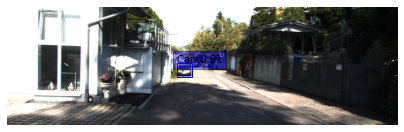

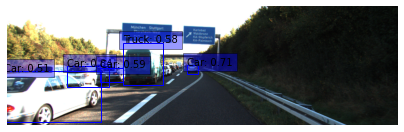

In [31]:
# 결과 확인
test_dataset = tfds.load("kitti", split="test", data_dir=DATA_PATH)
int2str = dataset_info.features["objects"]["type"].int2str

for sample in test_dataset.take(2):
    image = tf.cast(sample["image"], dtype=tf.float32)
    input_image, ratio = prepare_image(image)
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )

# Main mission

1. **KITTI 데이터셋에 대한 분석 및 가공**
    - x와 y좌표 위치 교체
    - 무작위로 수평 뒤집기(Flip)
    - 이미지 크기 조정 및 패딩 추가
    - 좌표계를 [x_min, y_min, x_max, y_max]에서 [x_min, y_min, width, height]으로 수정
       
       
2. **RetinaNet 학습**
    
    1 에포크당 ETA 25분 → 잠시 보류. 추후 시간 남으면 진행. 지금은 미리 학습된 모델 활용
    
    
3. **object detection 결과**
    1. 정성
    2. 정량
    
    
4. **자율주행 Object Detection 테스트시스템 적용결과 90% 이상의 정확도**
    - 사람이 한 명 이상 있는 경우 stop
    - 차량의 크기(width or height)가 300px이상인 경우 stop

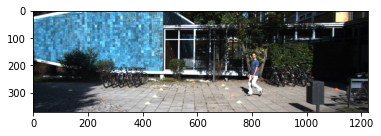

In [33]:
# 테스트 이미지 확인
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

img = Image.open(img_path)
plt.imshow(img)
plt.show()

In [34]:
# 사람이 한 명 이상 있는 경우 stop
# 추론 결과 내 검출된 오브젝트 내 사람이 있으면 stop

# 차량의 크기(width or height)가 300px이상인 경우 stop
# 추론 결과 'car' 가 검출되고 검출된 오브젝트의 바운딩박스 width or height가 300px 이상인 경우 stop

# 여기서 얘기한 300픽셀은 원본 이미지 기준에서 300픽셀이다. 
# 따라서 이미지 전처리 과정에서 바운딩박스 width or height 크기에 영향을 줄만한 것이 있는지 확인 필요.
# 생각해보니 resize_and_pad_image 이미지 함수에서 ratio를 반환해주고 있어 상관 없을 것 같다.

In [37]:
# 테스트 이미지 전처리

# 추론을 위한 데이터 전처리 파이프라인
def prepare_image(image):
    image, _, ratio = resize_and_pad_image(image, training=False)
    image = tf.keras.applications.resnet.preprocess_input(image)
    return tf.expand_dims(image, axis=0), ratio

input_image, ratio = prepare_image(image)
input_image, ratio

(<tf.Tensor: shape=(1, 512, 1408, 3), dtype=float32, numpy=
 array([[[[ 151.061  ,  138.22101,  131.32   ],
          [ 151.061  ,  138.22101,  131.32   ],
          [ 151.061  ,  138.22101,  131.32   ],
          ...,
          [-103.939  , -116.779  , -123.68   ],
          [-103.939  , -116.779  , -123.68   ],
          [-103.939  , -116.779  , -123.68   ]],
 
         [[ 151.061  ,  138.22101,  131.32   ],
          [ 151.061  ,  138.22101,  131.32   ],
          [ 151.061  ,  138.22101,  131.32   ],
          ...,
          [-103.939  , -116.779  , -123.68   ],
          [-103.939  , -116.779  , -123.68   ],
          [-103.939  , -116.779  , -123.68   ]],
 
         [[ 151.061  ,  138.22101,  131.32   ],
          [ 151.061  ,  138.22101,  131.32   ],
          [ 151.061  ,  138.22101,  131.32   ],
          ...,
          [-103.939  , -116.779  , -123.68   ],
          [-103.939  , -116.779  , -123.68   ],
          [-103.939  , -116.779  , -123.68   ]],
 
         ...,
 
      

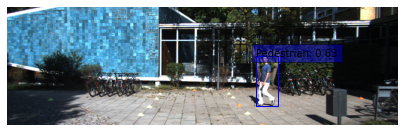

<AxesSubplot:>

In [41]:
# 원본 테스트 이미지
image = Image.open(img_path)

# 데이터 파이프라인
input_image, ratio = prepare_image(image)

# 추론 및 시각화
detections = inference_model.predict(input_image)
num_detections = detections.valid_detections[0]
class_names = [
    int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
]
visualize_detections(
    image,
    detections.nmsed_boxes[0][:num_detections] / ratio,
    class_names,
    detections.nmsed_scores[0][:num_detections],
)

In [50]:
# 추론 결과 내 검출된 오브젝트 내 사람이 있는지 확인

In [44]:
dataset_info.features["objects"]["type"]

ClassLabel(shape=(), dtype=tf.int64, num_classes=8)

In [46]:
for i in range(8):
    print(dataset_info.features["objects"]["type"].int2str(i))

Car
Van
Truck
Pedestrian
Person_sitting
Cyclist
Tram
Misc


In [48]:
class_list = list()
for i in range(8):
    class_list.append(dataset_info.features["objects"]["type"].int2str(i))
    
class_list

['Car',
 'Van',
 'Truck',
 'Pedestrian',
 'Person_sitting',
 'Cyclist',
 'Tram',
 'Misc']

In [49]:
is_person_ls = ('Pedestrian', 'Person_sitting', 'Cyclist')
is_person_ls

('Pedestrian', 'Person_sitting', 'Cyclist')

In [52]:
class_names

['Pedestrian']

In [56]:
if set(class_names) & set(is_person_ls):
    print("There's someone there.")

if not set(['Car', 'Van', 'Truck']) & set(is_person_ls):
    print("There's no one there.")

There's someone there.
There's no one there.


In [60]:
# width or height가 300px이상인지 확인

In [70]:
# 검축된 첫번째 bbox 데이터([y1, x1, y2, x2] 형식)
detections.nmsed_boxes[0][0]

array([849.9934 ,  66.03957, 924.9326 , 234.46005], dtype=float32)

In [71]:
height = detections.nmsed_boxes[0][0][2] - detections.nmsed_boxes[0][0][0]
width = detections.nmsed_boxes[0][0][3] - detections.nmsed_boxes[0][0][1]

width, height

(168.42047, 74.93921)

In [73]:
np.max([width, height])

168.42047

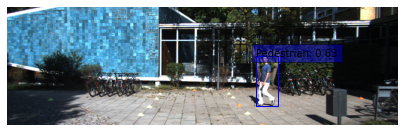

Stop


In [77]:
# stop & go 조건 합치기
img_path = os.getenv('HOME')+'/aiffel/object_detection/data/stop_1.png'

class_list = list()
for i in range(8):
    class_list.append(dataset_info.features["objects"]["type"].int2str(i))

is_person_ls = ('Pedestrian', 'Person_sitting', 'Cyclist')

def self_drive_assist(img_path, size_limit=300):
    # 원본 테스트 이미지
    image = Image.open(img_path)

    # 데이터 파이프라인
    input_image, ratio = prepare_image(image)

    # 추론 및 시각화
    detections = inference_model.predict(input_image)
    num_detections = detections.valid_detections[0]
    class_names = [
        int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
    ]
    visualize_detections(
        image,
        detections.nmsed_boxes[0][:num_detections] / ratio,
        class_names,
        detections.nmsed_scores[0][:num_detections],
    )
    
    # 조건에 따른 stop or go 출력
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"
    cond1 = set(class_names) & set(is_person_ls)
    
    bbox = detections.nmsed_boxes[0][0]
    height = bbox[2] - bbox[0]
    width = bbox[3] - bbox[1]
    cond2 = np.max([width, height]) >= size_limit
    
    if cond1 or cond2:
        return 'Stop'
        
    else:
        return 'Go'


print(self_drive_assist(img_path))

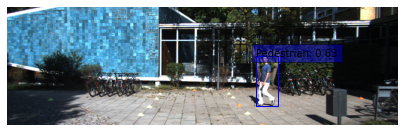

pred='Stop', answer='Stop'


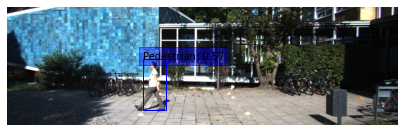

pred='Stop', answer='Stop'


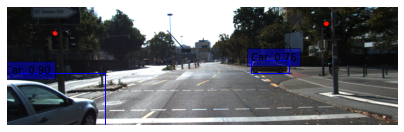

pred='Stop', answer='Stop'


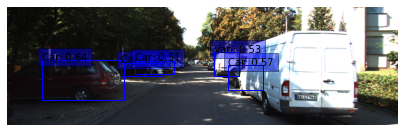

pred='Go', answer='Stop'


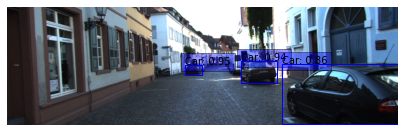

pred='Go', answer='Stop'


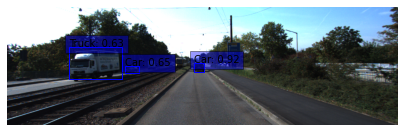

pred='Go', answer='Go'


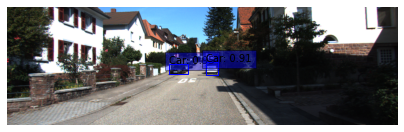

pred='Go', answer='Go'


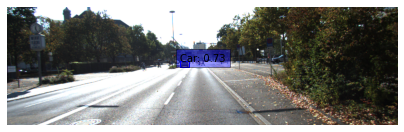

pred='Go', answer='Go'


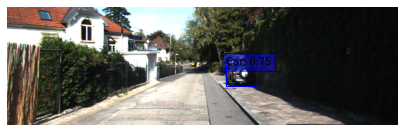

pred='Go', answer='Go'


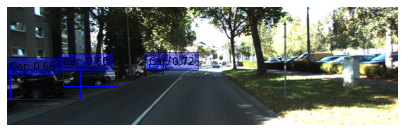

pred='Go', answer='Go'
80점입니다.


In [82]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
    score = 0
    test_set=[
        ("stop_1.png", "Stop"),
        ("stop_2.png", "Stop"),
        ("stop_3.png", "Stop"),
        ("stop_4.png", "Stop"),
        ("stop_5.png", "Stop"),
        ("go_1.png", "Go"),
        ("go_2.png", "Go"),
        ("go_3.png", "Go"),
        ("go_4.png", "Go"),
        ("go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        print(f'{pred=}, {answer=}')
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

# 평가

### 정성평가
- 4번 데이터의 경우 너무 큰 벤이 인식되지 않았다.
- 10번 데이터 내 많은 차량들이 존재하지만 담장에 가려지거나 많이 가려져 탐지를 제대로 못한다.
- 차량은 비교적 잘 탐지하고 신뢰도가 높은 편이지만, 사람은 신뢰도가 낮다. 좀 더 많은 샘플비교가 필요해 보인다.


### 정량 평가
- 주어진 테스크에서 정확도는 80%이다. 쉬운 Task인것을 감안하면 우수하지 못하다.
- 정량평가를 위한 Metric으로 IOU, Precision & Recall, AP(Average Precision) 등으로 매우 다양하게 존재한다.
- 시간관계상 정량평가는 수행하지 못했다.
- 현재 Task 기준으로는 사람 클래스는 유무가 중요하므로 Precision & Recall 또는 AP(Average Precision)이 유용할 것으로 사료된다.
- 차량 탐지의 경우에는 size기준이므로 IOU기반의 메트릭이 적절하다고 생각한다.